In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
bitwidth = 8
dim = 1
rng = "Sobol"
mode = "bipolar"
col = 100000

--- 0.26600003242492676 seconds ---
input error:  min: -0.0078125 max: 0.00390625
error distribution=========>


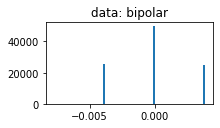

progressive accuracy=========>


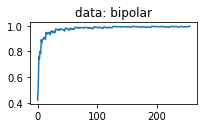

In [5]:
result_pe_cycle = []
if mode is "unipolar":
    iVec = torch.rand(1, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
elif mode is "bipolar":
    iVec = torch.rand(1, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode)().to(device)

iVecRNG = RNG(bitwidth, dim, rng)().to(device)
iVecBS = BSGen(iVecSource, iVecRNG).to(device)

iVecPE = ProgressiveError(iVec, mode=mode).to(device)
with torch.no_grad():
    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
    start_time = time.time()
    for i in range(2**bitwidth):
        iBS = iVecBS(idx + i)
        iVecPE.Monitor(iBS)
        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(iVecPE()[1][0], iVecPE()[1][0]))/col).item())
    print("--- %s seconds ---" % (time.time() - start_time))
    print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
    result_pe = iVecPE()[1][0].cpu().numpy()
    print("error distribution=========>")
    plt.figure(figsize=(3,1.5))
    fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
    plt.title("data: "+mode)
    plt.show()
    print("progressive accuracy=========>")
    plt.figure(figsize=(3,1.5))
    fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
    plt.title("data: "+mode)
    plt.show()